In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

plt.rcParams['axes.facecolor'] = 'lightgray'
sns.set(style="darkgrid")
np.set_printoptions(precision=3)

In [2]:
def boxplot_all_methods(plt_handle, res_all, title='', names=[], color=[]):
    res_all_df = pd.DataFrame(res_all.T)
    res_all_df.columns = names
    res_all_df_melt = res_all_df.melt(var_name='methods', value_name='accuracy')
    res_all_mean = np.mean(res_all, axis=1)
#     print(res_all_df_melt)
    print(res_all_df.shape, res_all_mean.shape, res_all_df_melt.shape)
    
#     plt_handle.set_title(title, fontsize=15)

    plt_handle.axhline(res_all_mean[2], ls='--', color='b')
    plt_handle.axhline(res_all_mean[1], ls='--', color='r')
    ax = sns.boxplot(x="methods", y="accuracy", data=res_all_df_melt, palette=color, ax=plt_handle)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-60, ha='left', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.yaxis.grid(False) # Hide the horizontal gridlines
    ax.xaxis.grid(True) # Show the vertical gridlines
    ax.set_xlabel("methods")
    ax.set_ylabel("accuracy")
    
    ax.set_xlabel("")
    ax.set_ylabel("Accuracy (%)", fontsize=15)

In [3]:
# perturb = 'whitepatch'
perturb = 'rotation'
M = 5
subset_prop = 0.2
lamL2 = 0.
lamL1 = 0.
lr = 1e-4
epochs= 100

In [4]:
names_short = ['Original', "Tar", "Src[1]",
               'DIP[1]', 'DIPweigh', 'CIP', 'CIRMweigh',
               'DIP[1]-MMD', 'DIPweigh-MMD', 'CIP-MMD', 'CIRMweigh-MMD']

prefix_template = 'results_MNIST/report_v8_%s_M%d_subsetprop%s_%s_lamMatch%s_lamCIP%s_lamMatchMMD%s_lamCIPMMD%s_epochs%d_seed%d'



In [5]:
repeats = 10
nb_ba = 3 # Original, Tar, Src[1]
results_src_ba = np.zeros((M-1, nb_ba, 2, 10))
results_tar_ba = np.zeros((nb_ba, 2, 10))
for seed in range(repeats):
    savefilename_prefix =  prefix_template % (perturb,
                                     M, str(subset_prop), 'baseline', 1., 0.1, 1., 0.1, epochs, seed)
    res = np.load("%s.npy" %savefilename_prefix, allow_pickle=True)

    results_src_ba[:, :, :, seed] =res.item()['src']
    results_tar_ba[:, :, seed] = res.item()['tar']

In [6]:
lamMatches = [10.**(k) for k in (np.arange(10)-5)]

In [7]:
# DAmean methods: DIP, DIPOracle, DIPweigh, CIRMweigh
nb_methods_damean = 4
repeats = 10
results_src_damean = np.zeros((len(lamMatches), M-1, nb_methods_damean, 2, 10))
results_tar_damean = np.zeros((len(lamMatches), nb_methods_damean, 2, 10))
for i, lam in enumerate(lamMatches):
    for seed in range(repeats):
        savefilename_prefix = prefix_template % (perturb,
                                     M, str(subset_prop), 'DAmean', lam, 10., lam, 10., epochs, seed)
        res = np.load("%s.npy" %savefilename_prefix, allow_pickle=True)

        results_src_damean[i, :, :, :, seed] =res.item()['src']
        results_tar_damean[i, :, :, seed] = res.item()['tar']

In [8]:
# choose lambda based on the source test performance
lam_index_damean = np.zeros(nb_methods_damean, dtype=int)
for i in range(nb_methods_damean):
    if i == 0 or i == 1:
        src_test_acc_all = results_src_damean[:, 0, i, 1, :].mean(axis=1)
    else:
        # M-2 for the source environment that is selected by weighting methods
        src_test_acc_all = results_src_damean[:, M-2, i, 1, :].mean(axis=1)
    # choose the largest lambda such that the source performance does not drop too much (5%)
    lam_index = 0
    for k, src_test_acc in enumerate(src_test_acc_all):
        
        if src_test_acc > np.max(src_test_acc_all) * 0.99:
            lam_index = k
    lam_index_damean[i] = lam_index
    print(lam_index, lamMatches[lam_index])

7 100.0
3 0.01
7 100.0
4 0.1


In [9]:
# DAMMD methods: DIP-MMD, DIPweigh-MMD, CIRMweigh-MMD
nb_methods_dammd = 3
repeats = 10
results_src_dammd = np.zeros((len(lamMatches), M-1, nb_methods_dammd, 2, 10))
results_tar_dammd = np.zeros((len(lamMatches), nb_methods_dammd, 2, 10))
for i, lam in enumerate(lamMatches):
    for seed in range(repeats):
        savefilename_prefix = prefix_template % (perturb,
                                     M, str(subset_prop), 'DAMMD', lam, 10., lam, 10., epochs, seed)
        res = np.load("%s.npy" %savefilename_prefix, allow_pickle=True)

        results_src_dammd[i, :, :, :, seed] =res.item()['src']
        results_tar_dammd[i, :, :, seed] = res.item()['tar']

In [10]:
# choose lambda based on the source test performance
lam_index_dammd = np.zeros(nb_methods_dammd, dtype=int)
for i in range(nb_methods_dammd):
    if i == 0:
        src_test_acc_all = results_src_dammd[:, 0, i, 1, :].mean(axis=1)
    else:
        # M-2 for the source environment that is selected by weighting methods
        src_test_acc_all = results_src_dammd[:, M-2, i, 1, :].mean(axis=1)
    # choose the largest lambda such that the source performance does not drop too much (5%)
    lam_index = 0
    for k, src_test_acc in enumerate(src_test_acc_all):
        if src_test_acc > np.max(src_test_acc_all) * 0.99:
            lam_index = k
    lam_index_dammd[i] = lam_index
    print(lam_index)

6
5
7


In [11]:
# DACIPmean methods
nb_methods_dacipmean = 1
repeats = 10
results_src_dacipmean = np.zeros((len(lamMatches), M-1, nb_methods_dacipmean, 2, 10))
results_tar_dacipmean = np.zeros((len(lamMatches), nb_methods_dacipmean, 2, 10))
for i, lam in enumerate(lamMatches):
    for seed in range(repeats):
        savefilename_prefix = prefix_template % (perturb,
                                     M, str(subset_prop), 'DACIPmean', 1., lam, 1., lam, 100, seed)
        res = np.load("%s.npy" %savefilename_prefix, allow_pickle=True)

        results_src_dacipmean[i, :, :, :, seed] = res.item()['src']
        results_tar_dacipmean[i, :, :, seed] = res.item()['tar']

In [12]:
# choose lambda based on the source test performance
lam_index_dacipmean = np.zeros(nb_methods_dacipmean, dtype=int)
for i in range(nb_methods_dacipmean):
    src_test_acc_all = results_src_dacipmean[:, :-1, i, 1, :].mean(axis=2).mean(axis=1)
    # choose the largest lambda such that the source performance does not drop too much (5%)
    lam_index = 0
    for k, src_test_acc in enumerate(src_test_acc_all):
        
        if src_test_acc > np.max(src_test_acc_all) * 0.99:
            lam_index = k
    lam_index_dacipmean[i] = lam_index
    print(lam_index, lamMatches[lam_index])

5 1.0


In [13]:
# DACIPMMD methods
nb_methods_dacipmmd = 1
repeats = 10
results_src_dacipmmd = np.zeros((len(lamMatches), M-1, nb_methods_dacipmmd, 2, 10))
results_tar_dacipmmd = np.zeros((len(lamMatches), nb_methods_dacipmmd, 2, 10))
for i, lam in enumerate(lamMatches):
    for seed in range(repeats):
        savefilename_prefix = prefix_template % (perturb,
                                     M, str(subset_prop), 'DACIPMMD', 1., lam, 1., lam, 100, seed)
        res = np.load("%s.npy" %savefilename_prefix, allow_pickle=True)

        results_src_dacipmmd[i, :, :, :, seed] = res.item()['src']
        results_tar_dacipmmd[i, :, :, seed] = res.item()['tar']

In [14]:
# choose lambda based on the source test performance
lam_index_dacipmmd = np.zeros(nb_methods_dacipmmd, dtype=int)
for i in range(nb_methods_dacipmmd):
    src_test_acc_all = results_src_dacipmmd[:, :-1, i, 1, :].mean(axis=2).mean(axis=1)
    # choose the largest lambda such that the source performance does not drop too much (5%)
    lam_index = 0
    for k, src_test_acc in enumerate(src_test_acc_all):
        
        if src_test_acc > np.max(src_test_acc_all) * 0.99:
            lam_index = k
    lam_index_dacipmmd[i] = lam_index
    print(lam_index, lamMatches[lam_index])

6 10.0


In [15]:
lam_index_damean[[0, 2, 3]]

array([7, 7, 4])

In [16]:
test_err_index = 0

results_tar_plot = np.concatenate((results_tar_ba[:, test_err_index, :],
                                   results_tar_damean[lam_index_damean[0], 0, test_err_index, :].reshape((-1, 10), order='F'),
                                   results_tar_damean[lam_index_damean[2], 2, test_err_index, :].reshape((-1, 10), order='F'),
                                   results_tar_dacipmean[lam_index_dacipmean, 0, test_err_index, :].reshape((-1, 10), order='F'),
                                   results_tar_damean[lam_index_damean[3], 3, test_err_index, :].reshape((-1, 10), order='F'),
                                   results_tar_dammd[lam_index_dammd[0], 0, test_err_index, :].reshape((-1, 10), order='F'),
                                   results_tar_dammd[lam_index_dammd[1], 1, test_err_index, :].reshape((-1, 10), order='F'),
                                   results_tar_dacipmmd[lam_index_dacipmmd, 0, test_err_index, :].reshape((-1, 10), order='F'),
                                   results_tar_dammd[lam_index_dammd[2], 2, test_err_index, :].reshape((-1, 10), order='F')), axis=0)
                                   


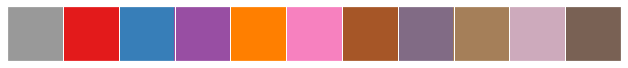

In [17]:
COLOR_PALETTE1 = sns.color_palette("Set1", 9, desat=1.)
COLOR_PALETTE2 = sns.color_palette("Set1", 9, desat=.7)
COLOR_PALETTE3 = sns.color_palette("Set1", 9, desat=.5)
COLOR_PALETTE4 = sns.color_palette("Set1", 9, desat=.3)
# COLOR_PALETTE2 = sns.color_palette("Dark2", 30)
# COLOR_PALETTE = COLOR_PALETTE1[:8] + COLOR_PALETTE2[:30]
COLOR_PALETTE = [COLOR_PALETTE1[8], COLOR_PALETTE1[0], COLOR_PALETTE1[1],
                 COLOR_PALETTE1[3], COLOR_PALETTE1[4], COLOR_PALETTE1[7], 
                 COLOR_PALETTE1[6], 
                 COLOR_PALETTE4[3], COLOR_PALETTE4[4], COLOR_PALETTE4[7], 
                 COLOR_PALETTE4[6]]
sns.palplot(COLOR_PALETTE)


(10, 11) (11,) (110, 2)


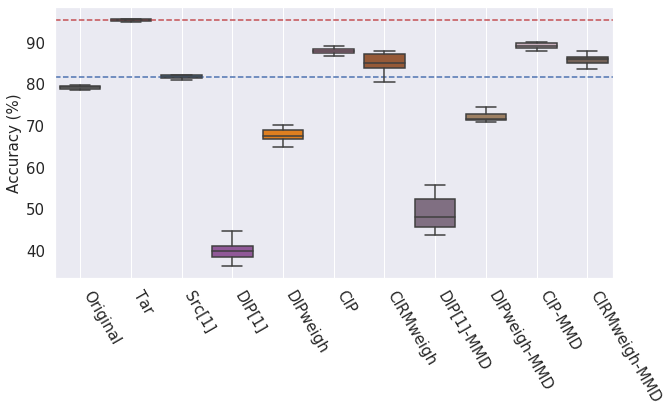

In [18]:
# hyperparameter choice plot
fig, axs = plt.subplots(1, 1, figsize=(10,5))
boxplot_all_methods(axs, results_tar_plot*100,
                     title="", names=names_short,
                     color=np.array(COLOR_PALETTE)[:len(names_short)])

plt.savefig("paper_figures/MNIST_%s_M5_Yintervention.pdf" %perturb, bbox_inches="tight")
plt.show()